# Hotel Review Classification

### Team 1: Renetta Nelson, Jacqueline Urenda

### June 26, 2023

## Importing Libraries

In [104]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import csv
import time
import random
from collections import OrderedDict
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import pyLDAvis.lda_model
import nltk
import random



from nltk.stem import WordNetLemmatizer
from random import randint
from textblob import TextBlob
from time import sleep

color = sns.color_palette()
%matplotlib inline



from collections import Counter, defaultdict
from string import punctuation
from nltk.corpus import stopwords
from nltk.metrics import ConfusionMatrix

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.model_selection import train_test_split


from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator


In [2]:
#import nltk
#nltk.download('wordnet')

## Retrieving Data from Website

In [3]:

hotel_page1 = ("https://www.tripadvisor.in/Hotels-g60750-San_Diego_California-Hotels.html")
hotel_page2 = ("https://www.tripadvisor.in/Hotels-g60750-oa30-San_Diego_California-Hotels.html")
hotel_page3 = ("https://www.tripadvisor.in/Hotels-g60750-oa60-San_Diego_California-Hotels.html")
hotel_page4 = ("https://www.tripadvisor.in/Hotels-g60750-oa90-San_Diego_California-Hotels.html")
hotel_page5 = ("https://www.tripadvisor.in/Hotels-g60750-oa120-San_Diego_California-Hotels.html")
hotel_page6 = ("https://www.tripadvisor.in/Hotels-g60750-oa150-San_Diego_California-Hotels.html")
hotel_page7 = ("https://www.tripadvisor.in/Hotels-g60750-oa180-San_Diego_California-Hotels.html")
hotel_page8 = ("https://www.tripadvisor.in/Hotels-g60750-oa210-San_Diego_California-Hotels.html")
hotel_page9 = ("https://www.tripadvisor.in/Hotels-g60750-oa240-San_Diego_California-Hotels.html")
hotel_page10 = ("https://www.tripadvisor.in/Hotels-g60750-oa270-San_Diego_California-Hotels.html")

user_agent = ( {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \ AppleWebKit/537.36 (KHTML, like Gecko) \ Chrome/90.0.4430.212 Safari/537.36',
                'Accept-Language': 'en-US, en'})


hp1= requests.get(hotel_page1, headers = user_agent)
hp2= requests.get(hotel_page2, headers = user_agent)
hp3= requests.get(hotel_page3, headers = user_agent)
hp4= requests.get(hotel_page4, headers = user_agent)
hp5= requests.get(hotel_page5, headers = user_agent)
hp6= requests.get(hotel_page6, headers = user_agent)
hp7= requests.get(hotel_page7, headers = user_agent)
hp8= requests.get(hotel_page8, headers = user_agent)
hp9= requests.get(hotel_page9, headers = user_agent)
hp10= requests.get(hotel_page10, headers = user_agent)

## Extracting the Data

### Data Extraction for Each Hotel

In [4]:
def extract(h_page, hotel_names, hotel_ratings, hotel_reviews, hotel_prices):

    h_content = BeautifulSoup(h_page.content, 'html.parser')

    for hotel_name in h_content.find_all('div', {'class': 'listing_title'}):
        hotel_names.append(hotel_name.text.strip())


    for hotel_rating in h_content.find_all('a', {'class': 'ui_bubble_rating'}):
        hotel_ratings.append(hotel_rating['alt'])

    for hotel_review in h_content.find_all('a', {'class': 'review_count'}):
        hotel_reviews.append(hotel_review.text.strip())

    for hotel_price in h_content.find_all('span', {'class': 'fwoto'}):
        print("In pricing")
        hotel_prices.append(hotel_price.span.text.replace('₹','').strip())
    

    return hotel_names, hotel_ratings, hotel_reviews, hotel_prices


def extract_test(hotel_names, hotel_ratings, hotel_reviews, hotel_prices):
    print("Lengths of Dataset Columns")
    print("Hotel Names: ", len(hotel_names))
    print("Hotel Ratings: ", len(hotel_ratings))
    print("Hotel Reviews: ", len(hotel_reviews))
    print("Hotel Prices: ", len(hotel_prices))

In [5]:
hotel_names = []
hotel_ratings = []
hotel_reviews = []
hotel_prices = []


hotel_names, hotel_ratings, hotel_reviews, hotel_prices = extract(hp1, hotel_names, hotel_ratings, hotel_reviews, hotel_prices)
hotel_names, hotel_ratings, hotel_reviews, hotel_prices = extract(hp2, hotel_names, hotel_ratings, hotel_reviews, hotel_prices)
hotel_names, hotel_ratings, hotel_reviews, hotel_prices = extract(hp3, hotel_names, hotel_ratings, hotel_reviews, hotel_prices)
hotel_names, hotel_ratings, hotel_reviews, hotel_prices = extract(hp4, hotel_names, hotel_ratings, hotel_reviews, hotel_prices)
hotel_names, hotel_ratings, hotel_reviews, hotel_prices = extract(hp5, hotel_names, hotel_ratings, hotel_reviews, hotel_prices)
hotel_names, hotel_ratings, hotel_reviews, hotel_prices = extract(hp6, hotel_names, hotel_ratings, hotel_reviews, hotel_prices)
hotel_names, hotel_ratings, hotel_reviews, hotel_prices = extract(hp7, hotel_names, hotel_ratings, hotel_reviews, hotel_prices)
hotel_names, hotel_ratings, hotel_reviews, hotel_prices = extract(hp8, hotel_names, hotel_ratings, hotel_reviews, hotel_prices)
hotel_names, hotel_ratings, hotel_reviews, hotel_prices = extract(hp9, hotel_names, hotel_ratings, hotel_reviews, hotel_prices)
hotel_names, hotel_ratings, hotel_reviews, hotel_prices = extract(hp10, hotel_names, hotel_ratings, hotel_reviews, hotel_prices)




In [6]:
extract_test(hotel_names, hotel_ratings, hotel_reviews, hotel_prices)

Lengths of Dataset Columns
Hotel Names:  600
Hotel Ratings:  300
Hotel Reviews:  300
Hotel Prices:  0


### Data Extraction of Reviews for Each Hotel

In [7]:
def extract_review(url):
    
    hotel_rev = []
    hotel_rev2 = []
    hotel_rev3 = []

    review_page= (url)

    user_agent = ( {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \ AppleWebKit/537.36 (KHTML, like Gecko) \ Chrome/90.0.4430.212 Safari/537.36',
                    'Accept-Language': 'en-US, en'})


    rp1= requests.get(review_page, headers = user_agent)

    h_content = BeautifulSoup(rp1.content, 'html.parser')


    for rp_1 in h_content.findAll('span', {'class':'QewHA H4 _a'}):
        hotel_rev.append(rp_1.span.text.strip())


    for rp_2 in h_content.findAll('a', {'class':'Qwuub'}):
        hotel_rev2.append(rp_2.text.strip())

    for rp_3 in h_content.findAll("span", {"class": "ui_bubble_rating"}):
        hotel_rev3.append(rp_3)


    return hotel_rev2, hotel_rev3, hotel_rev



def extract_links(hotel_link, links):

    for review in hotel_link.findAll('a',{'class': 'review_count'}):
        a = review['href']
        a = 'https://www.tripadvisor.in'+ a

        a= a[:(a.find('Reviews')+7)] + '-or{}' + a[(a.find('Reviews')+7):]
  
        links.append(a)
    #return links

In [8]:
hotel_rev = BeautifulSoup(hp1.content, 'html.parser')
hotel_rev2 = BeautifulSoup(hp2.content, "html.parser")
hotel_rev3 = BeautifulSoup(hp3.content, "html.parser")
hotel_rev4 = BeautifulSoup(hp4.content, "html.parser")
hotel_rev5 = BeautifulSoup(hp5.content, "html.parser")
hotel_rev6 = BeautifulSoup(hp6.content, "html.parser")
hotel_rev7 = BeautifulSoup(hp7.content, "html.parser")
hotel_rev8 = BeautifulSoup(hp8.content, "html.parser")
hotel_rev9 = BeautifulSoup(hp9.content, "html.parser")
hotel_rev10 = BeautifulSoup(hp10.content, "html.parser")


links = []

extract_links(hotel_rev, links)
extract_links(hotel_rev2, links)
extract_links(hotel_rev3, links)
extract_links(hotel_rev4, links)
extract_links(hotel_rev5, links)
extract_links(hotel_rev6, links)
extract_links(hotel_rev7, links)
extract_links(hotel_rev8, links)
extract_links(hotel_rev9, links)
extract_links(hotel_rev10, links)



## Data Transformation

In [9]:
def cleaning_data(hotel_names, hotel_ratings, hotel_reviews, links):
    hotel_names2 = []
    hotel_names3 = []
    hotel_names4 = []
    hotel_reviews2 = []
    hotel_reviews3 = []
    hotel_ratings2 = []
    hotel_ratings3 = []
    name_index = []
    links2 = []
    num = 0
    temp = 0

    # removing duplicates of hotel names
    n = 0
    for i in hotel_names:
        if n % 2 == 0:
            n = n + 1
            hotel_names2.append(i)
        else:
            n = n + 1
            continue 

 

    # remove "Sponsored" hotels

    for i in hotel_names2:
        #print(i)
        x = i.split(" ")
        if x[0] == "Sponsored":
            name_index.append(num)
            num = num + 1
            continue
        else:
            hotel_names3.append(" ".join(x))
            num = num + 1



    # removing numbers from hotel names

    for i in hotel_names3:
        x = i.split(" ")
        del x[0]
        hotel_names4.append(" ".join(x))



    # Removing word "reviews" from column values and converting to numerical 

    for i in hotel_reviews:
        x = i.split(" ")
        for y in x:
            c = re.sub(r'[^\w\s]', '', y)
            if c.isdigit():
                hotel_reviews2.append(c)
            else:
                continue

    hotel_reviews2 = [eval(i) for i in hotel_reviews2]


    # Removing Sponsored hotel reviews



    for i in range(len(hotel_reviews2)):

        if i not in name_index:
                hotel_reviews3.append(hotel_reviews2[i])
        else:
            continue



    # Removing Sponsored hotel ratings

   
    for i in range(len(hotel_ratings)):

        if i not in name_index:
                hotel_ratings2.append(hotel_ratings[i])
        else:
            continue
        


    # Only taking rating and converting into numerical 

    for i in hotel_ratings2:
        x = i.split(" ")
        hotel_ratings3.append(x[0])

    hotel_ratings3 = [eval(i) for i in hotel_ratings3]



    # removing links to reviews for sponsored hotels


    for i in range(len(links)):

        if i not in name_index:
                links2.append(links[i])
        else:
            continue

    
    
    # Extracting review content from links

    reviews = []
    rev_dict = {}
    rev_title = []
    rev_rate = []
    rev_summary = []


    for link in links2:
        title, rate, summary = extract_review(link)
        rev_title.append(title)
        rev_rate.append(rate)
        rev_summary.append(summary)



    # Converting each review rating to numerical

    rev_rate2 = []

    rev_rate4 = []

    for i in rev_rate:
        temp2 = []
        for j in i:
            temp2.append(str(j))
        rev_rate2.append(temp2)
        


    for x in rev_rate2:
        temp3 = []
        for y in x:
            #print(y)
            y1 = y.split(" ")
            y2 = y1[2].split('"')
            y3 = y2[0].split("_")
            n = int(y3[1]) / 10
            temp3.append(n)
            #print(y3)
        rev_rate4.append(temp3)



    return hotel_names4, hotel_ratings3, hotel_reviews3, name_index, rev_title, rev_rate4, rev_summary



def clean_data_test(hotel_names3, hotel_ratings2, hotel_reviews2):
    print("Lengths of Dataset Columns")
    print("Hotel Names: ", len(hotel_names3))
    print("Hotel Ratings: ", len(hotel_ratings2))
    print("Hotel Reviews: ", len(hotel_reviews2))

In [11]:
hotel_names4, hotel_ratings3, hotel_reviews3, name_index, rev_title, rev_rate4, rev_summary = cleaning_data(hotel_names, hotel_ratings, hotel_reviews, links)


In [12]:
clean_data_test(hotel_names4, hotel_ratings3, hotel_reviews3)

Lengths of Dataset Columns
Hotel Names:  300
Hotel Ratings:  300
Hotel Reviews:  300


## Loading Cleaned Data into a DataFrame

### Loading Hotel Data

In [13]:

hotels_dict = {}

# Load data into dictionary

hotels_dict = {'names':hotel_names4, 'num_reviews':hotel_reviews3, 'ratings':hotel_ratings3}   #, 'costs':hotel_prices[:37]}


hotels_df = pd.DataFrame.from_dict(hotels_dict)
hotels_df.head(10)

,names,num_reviews,ratings
0,Bahia Resort Hotel,6376,4.5
1,Manchester Grand Hyatt San Diego,12651,4.5
2,Embassy Suites by Hilton San Diego Bay Downtown,3444,4.5
3,San Diego Mission Bay Resort,1368,4.0
4,San Diego Marriott La Jolla,1508,4.5
5,Paradise Point Resort & Spa,3204,4.0
6,Catamaran Resort Hotel and Spa,6754,4.5
7,Best Western Plus Island Palms Hotel & Marina,4854,4.5
8,Old Town Inn,2412,4.5
9,Marriott Marquis San Diego Marina,4891,4.0


### Loading Reviews for Each Hotel

In [14]:

hotels_df["review_title"] = rev_title
hotels_df["review_rating"] = rev_rate4
hotels_df["review_summary"] = rev_summary

hotels_df.head(10)

,names,num_reviews,ratings,review_title,review_rating,review_summary
0,Bahia Resort Hotel,6376,4.5,"[THE place to stay in San Diego, Outstanding l...","[4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.5, 4.0, 4.5, ...",[This is my third trip to The Bahia and it has...
1,Manchester Grand Hyatt San Diego,12651,4.5,"[AVID Training, Great Stay Near Convention Cen...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...",[This was a teacher AVID Summer Institute Trai...
2,Embassy Suites by Hilton San Diego Bay Downtown,3444,4.5,"[Great Location and customer service., Absolut...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...","[Best employee Vanessa, front desk. The hotel ..."
3,San Diego Mission Bay Resort,1368,4.0,"[Conference held at SDMB Resort, Excellent fro...","[4.0, 4.0, 4.5, 4.0, 4.0, 3.5, 5.0, 4.5, 4.5, ...",[The company I work for had a conference/train...
4,San Diego Marriott La Jolla,1508,4.5,"[Best Hotel Experience is amazing!, Amazing ti...","[4.5, 4.5, 4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.0, ...",[I have to first off say the food is absolutel...
5,Paradise Point Resort & Spa,3204,4.0,"[Great location, poor rooms and service, Beaut...","[4.0, 4.0, 4.5, 4.0, 4.0, 4.0, 4.5, 5.0, 5.0, ...","[The location is great, the property is beauti..."
6,Catamaran Resort Hotel and Spa,6754,4.5,"[Sushi till you drop, Phenomenal stay!, Deluxe...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...",[Always loved staying at the beautiful Catamar...
7,Best Western Plus Island Palms Hotel & Marina,4854,4.5,[Nice stay but pay for parking and no free bre...,"[4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.0, ...",[Great location. Rooms were spacious and had r...
8,Old Town Inn,2412,4.5,"[Not super great, but not entirely bad, Fantas...","[4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, ...",[Booked this for our San Diego trip. The sink ...
9,Marriott Marquis San Diego Marina,4891,4.0,"[Nice hotel but no lounge on weekends., A Good...","[4.0, 4.0, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...",[The hotel is quite nice. Apparently just fin...


### Loading the "hotels_df.csv" file 
 In case of "Access Denied" during web scraping

In [2]:
hotels_df = pd.read_csv('hotels_df.csv')

hotels_df = hotels_df.iloc[: , 1:]

In [3]:
hotels_df.head()


,names,num_reviews,ratings,review_title,review_rating,review_summary
0,Bahia Resort Hotel,6370,4.5,"['Great stay!', 'Outstanding large boutique re...","[4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.5, 4.0, 4.5, ...",['We had a great stay at the Bahia Resort in S...
1,Manchester Grand Hyatt San Diego,12646,4.5,"['Excellent hotel', 'Great Stay Near Conventio...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...",['The price is very reasonable and the view fr...
2,Embassy Suites by Hilton San Diego Bay Downtown,3444,4.5,"['Great location near Seaport Village, USS Mid...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...","['Great location near Seaport Village, USS Mid..."
3,San Diego Mission Bay Resort,1365,4.0,"['Beautiful Place to Stay', 'Excellent from st...","[4.0, 4.0, 4.5, 4.0, 4.0, 3.5, 5.0, 4.5, 4.5, ...","['Hotel was clean, rooms are large and balconi..."
4,San Diego Marriott La Jolla,1505,4.5,['Probably won’t stay at this location again.'...,"[4.5, 4.5, 4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.0, ...",['Room was nice enough but the lack of houseke...


## Exploratory Data Analysis

### Plotting the Distribution of Hotel Ratings

In [4]:
color = sns.color_palette()
%matplotlib inline
fig = px.histogram(hotels_df, x="ratings",  width=800, height=400)
fig.update_traces(marker_color="pink",marker_line_color='orchid',
                  marker_line_width=1.5)
fig.update_layout(title_text='Hotel Ratings Distribution')
fig.show()

 - There are less hotels with a ratings score of less than 3. Majority of hotel guests that have written a review have a positive experience. 

## Data Preparation

### Functions

In [5]:
#punctuation
punctuation = set(punctuation) 
tw_punct = punctuation - {"#"}

#stopwords and null removal

sw = stopwords.words("english")
sw = sw + ['nan']

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")


# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum(len(token) for token in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])    

# Function to remove stop words:

def remove_stop(tokens) :
    

    return[t for t in tokens if t not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    return([item.lower() for item in whitespace_pattern.split(text)])
    

full_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]


def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

### Descriptive Statistics

- Needs to be Completed

### Tokenization

In [6]:

hotels_df['title_tokens']= hotels_df['review_title'].apply(prepare, pipeline=full_pipeline)
hotels_df['summary_tokens']= hotels_df['review_summary'].apply(prepare, pipeline=full_pipeline)

hotels_df.head()

,names,num_reviews,ratings,review_title,review_rating,review_summary,title_tokens,summary_tokens
0,Bahia Resort Hotel,6370,4.5,"['Great stay!', 'Outstanding large boutique re...","[4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.5, 4.0, 4.5, ...",['We had a great stay at the Bahia Resort in S...,"[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ..."
1,Manchester Grand Hyatt San Diego,12646,4.5,"['Excellent hotel', 'Great Stay Near Conventio...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...",['The price is very reasonable and the view fr...,"[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,..."
2,Embassy Suites by Hilton San Diego Bay Downtown,3444,4.5,"['Great location near Seaport Village, USS Mid...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...","['Great location near Seaport Village, USS Mid...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, uss,..."
3,San Diego Mission Bay Resort,1365,4.0,"['Beautiful Place to Stay', 'Excellent from st...","[4.0, 4.0, 4.5, 4.0, 4.0, 3.5, 5.0, 4.5, 4.5, ...","['Hotel was clean, rooms are large and balconi...","[beautiful, place, stay, excellent, start, fin...","[hotel, clean, rooms, large, balconies, provid..."
4,San Diego Marriott La Jolla,1505,4.5,['Probably won’t stay at this location again.'...,"[4.5, 4.5, 4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.0, ...",['Room was nice enough but the lack of houseke...,"[probably, won’t, stay, location, excellent, c...","[room, nice, enough, lack, housekeeping, visib..."


### Lemmatization

In [7]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text

hotels_df['title_lemma'] = hotels_df['title_tokens'].apply(lambda x: word_lemmatizer(x))
hotels_df['summary_lemma'] = hotels_df['summary_tokens'].apply(lambda x: word_lemmatizer(x))

hotels_df.head()

,names,num_reviews,ratings,review_title,review_rating,review_summary,title_tokens,summary_tokens,title_lemma,summary_lemma
0,Bahia Resort Hotel,6370,4.5,"['Great stay!', 'Outstanding large boutique re...","[4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.5, 4.0, 4.5, ...",['We had a great stay at the Bahia Resort in S...,"[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ...","[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ..."
1,Manchester Grand Hyatt San Diego,12646,4.5,"['Excellent hotel', 'Great Stay Near Conventio...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...",['The price is very reasonable and the view fr...,"[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,...","[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,..."
2,Embassy Suites by Hilton San Diego Bay Downtown,3444,4.5,"['Great location near Seaport Village, USS Mid...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...","['Great location near Seaport Village, USS Mid...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, us, ...","[great, location, near, seaport, village, us, ..."
3,San Diego Mission Bay Resort,1365,4.0,"['Beautiful Place to Stay', 'Excellent from st...","[4.0, 4.0, 4.5, 4.0, 4.0, 3.5, 5.0, 4.5, 4.5, ...","['Hotel was clean, rooms are large and balconi...","[beautiful, place, stay, excellent, start, fin...","[hotel, clean, rooms, large, balconies, provid...","[beautiful, place, stay, excellent, start, fin...","[hotel, clean, room, large, balcony, provide, ..."
4,San Diego Marriott La Jolla,1505,4.5,['Probably won’t stay at this location again.'...,"[4.5, 4.5, 4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.0, ...",['Room was nice enough but the lack of houseke...,"[probably, won’t, stay, location, excellent, c...","[room, nice, enough, lack, housekeeping, visib...","[probably, won’t, stay, location, excellent, c...","[room, nice, enough, lack, housekeeping, visib..."


## Sentiment Analysis

### Calculating Sentiment

In [8]:
#converting lemmatized data into string

hotels_df['title_lemma_str'] = [' '.join(map(str,l)) for l in hotels_df['title_lemma']]
hotels_df['summary_lemma_str'] = [' '.join(map(str,l)) for l in hotels_df['summary_lemma']]


hotels_df.head()

,names,num_reviews,ratings,review_title,review_rating,review_summary,title_tokens,summary_tokens,title_lemma,summary_lemma,title_lemma_str,summary_lemma_str
0,Bahia Resort Hotel,6370,4.5,"['Great stay!', 'Outstanding large boutique re...","[4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.5, 4.0, 4.5, ...",['We had a great stay at the Bahia Resort in S...,"[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ...","[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ...",great stay outstanding large boutique resort g...,great stay bahia resort san diego ben front de...
1,Manchester Grand Hyatt San Diego,12646,4.5,"['Excellent hotel', 'Great Stay Near Conventio...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...",['The price is very reasonable and the view fr...,"[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,...","[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,...",excellent hotel great stay near convention cen...,price reasonable view window great easy fast c...
2,Embassy Suites by Hilton San Diego Bay Downtown,3444,4.5,"['Great location near Seaport Village, USS Mid...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...","['Great location near Seaport Village, USS Mid...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, us, ...","[great, location, near, seaport, village, us, ...",great location near seaport village us midway ...,great location near seaport village us midway ...
3,San Diego Mission Bay Resort,1365,4.0,"['Beautiful Place to Stay', 'Excellent from st...","[4.0, 4.0, 4.5, 4.0, 4.0, 3.5, 5.0, 4.5, 4.5, ...","['Hotel was clean, rooms are large and balconi...","[beautiful, place, stay, excellent, start, fin...","[hotel, clean, rooms, large, balconies, provid...","[beautiful, place, stay, excellent, start, fin...","[hotel, clean, room, large, balcony, provide, ...",beautiful place stay excellent start finish re...,hotel clean room large balcony provide beautif...
4,San Diego Marriott La Jolla,1505,4.5,['Probably won’t stay at this location again.'...,"[4.5, 4.5, 4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.0, ...",['Room was nice enough but the lack of houseke...,"[probably, won’t, stay, location, excellent, c...","[room, nice, enough, lack, housekeeping, visib...","[probably, won’t, stay, location, excellent, c...","[room, nice, enough, lack, housekeeping, visib...",probably won’t stay location excellent custome...,room nice enough lack housekeeping visible toi...


In [9]:
hotels_df['title_sentiment'] = hotels_df['title_lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
hotels_df['summary_sentiment'] = hotels_df['summary_lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)

hotels_df.head()

,names,num_reviews,ratings,review_title,review_rating,review_summary,title_tokens,summary_tokens,title_lemma,summary_lemma,title_lemma_str,summary_lemma_str,title_sentiment,summary_sentiment
0,Bahia Resort Hotel,6370,4.5,"['Great stay!', 'Outstanding large boutique re...","[4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.5, 4.0, 4.5, ...",['We had a great stay at the Bahia Resort in S...,"[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ...","[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ...",great stay outstanding large boutique resort g...,great stay bahia resort san diego ben front de...,0.506494,0.281789
1,Manchester Grand Hyatt San Diego,12646,4.5,"['Excellent hotel', 'Great Stay Near Conventio...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...",['The price is very reasonable and the view fr...,"[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,...","[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,...",excellent hotel great stay near convention cen...,price reasonable view window great easy fast c...,0.673333,0.407880
2,Embassy Suites by Hilton San Diego Bay Downtown,3444,4.5,"['Great location near Seaport Village, USS Mid...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...","['Great location near Seaport Village, USS Mid...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, us, ...","[great, location, near, seaport, village, us, ...",great location near seaport village us midway ...,great location near seaport village us midway ...,0.543056,0.404851
3,San Diego Mission Bay Resort,1365,4.0,"['Beautiful Place to Stay', 'Excellent from st...","[4.0, 4.0, 4.5, 4.0, 4.0, 3.5, 5.0, 4.5, 4.5, ...","['Hotel was clean, rooms are large and balconi...","[beautiful, place, stay, excellent, start, fin...","[hotel, clean, rooms, large, balconies, provid...","[beautiful, place, stay, excellent, start, fin...","[hotel, clean, room, large, balcony, provide, ...",beautiful place stay excellent start finish re...,hotel clean room large balcony provide beautif...,0.432143,0.223431
4,San Diego Marriott La Jolla,1505,4.5,['Probably won’t stay at this location again.'...,"[4.5, 4.5, 4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.0, ...",['Room was nice enough but the lack of houseke...,"[probably, won’t, stay, location, excellent, c...","[room, nice, enough, lack, housekeeping, visib...","[probably, won’t, stay, location, excellent, c...","[room, nice, enough, lack, housekeeping, visib...",probably won’t stay location excellent custome...,room nice enough lack housekeeping visible toi...,0.401515,0.252619


### Distribution Plot

In [10]:
%matplotlib inline
fig2 = px.histogram(hotels_df, x="title_sentiment",  width=800, height=400)
fig2.update_traces(marker_color="pink",marker_line_color='orchid',
                  marker_line_width=1.5)
fig2.update_layout(title_text='Review Title Sentiment Distribution')
fig2.show()

%matplotlib inline
fig3 = px.histogram(hotels_df, x="summary_sentiment",  width=800, height=400)
fig3.update_traces(marker_color="pink",marker_line_color='orchid',
                  marker_line_width=1.5)
fig3.update_layout(title_text='Review Summary Sentiment Distribution')
fig3.show()

- Sentiment distribution looks like normal

## Word Clouds

### Hotel Review Titles

In [11]:

title_words = hotels_df["title_lemma"]

total_words = []

for x in title_words:
    total_words = total_words + x

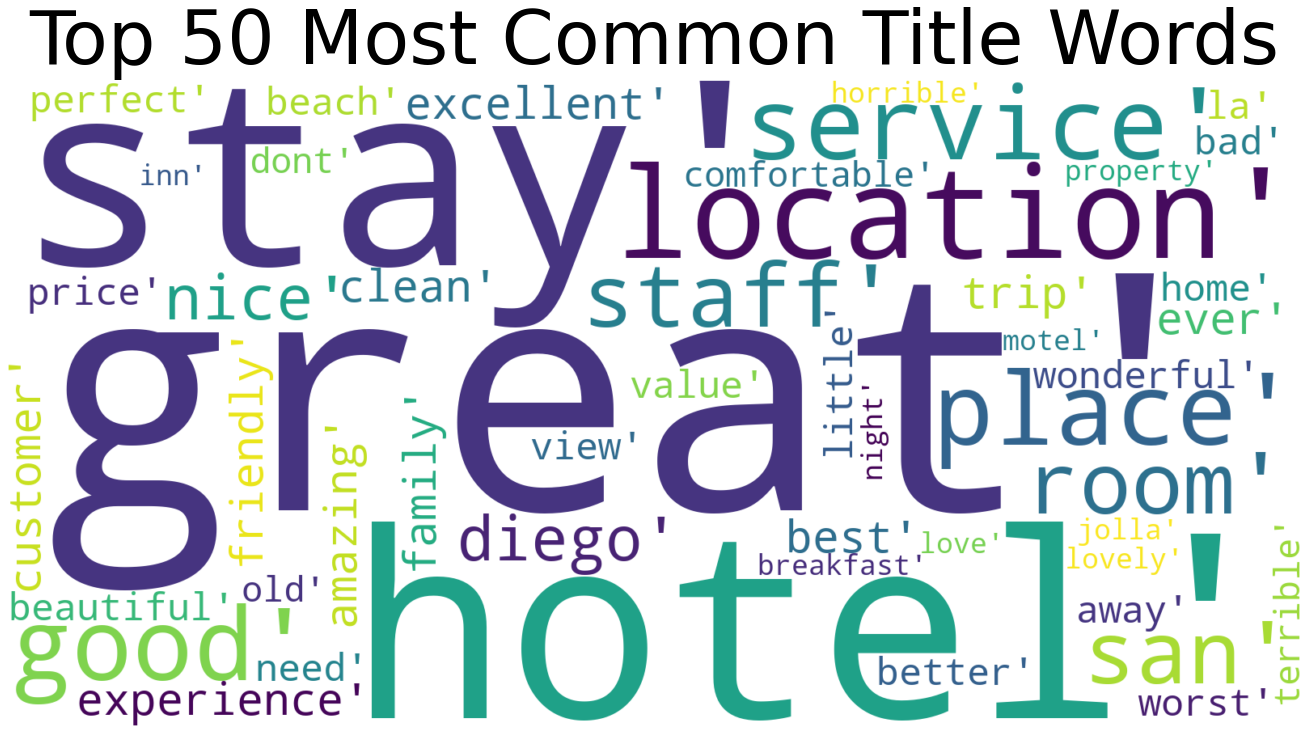

In [12]:
mode = FreqDist(total_words).most_common(50)

cloud = WordCloud(width=1600, height = 800, background_color = 'white').generate(str(mode))

fig = plt.figure(figsize=(30, 10), facecolor='white')
plt.imshow(cloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Most Common Title Words', fontsize = 75)
plt.tight_layout(pad=0)
plt.show()


### Hotel Review Summaries

In [13]:

title_words = hotels_df["summary_lemma"]

total_words = []

for x in title_words:
    total_words = total_words + x
    

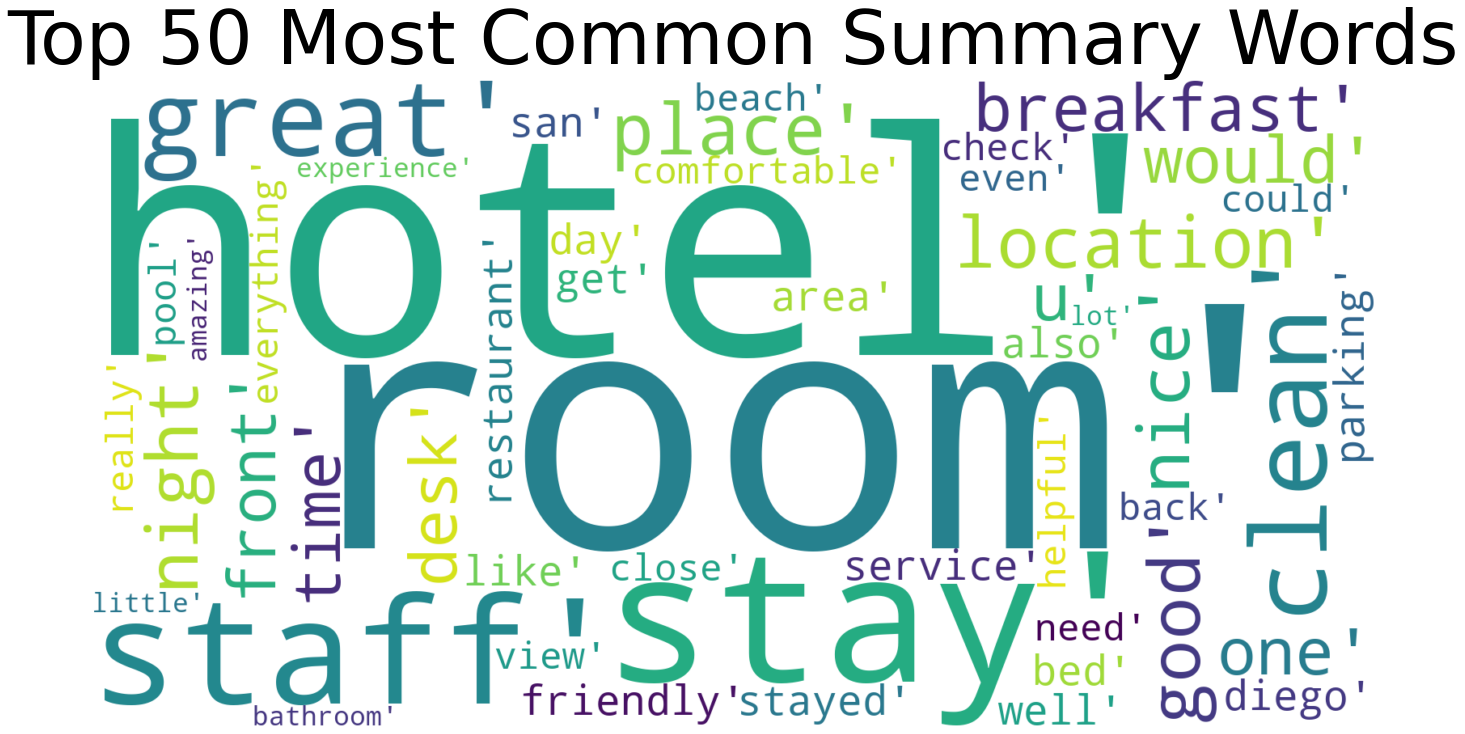

In [14]:

mode = FreqDist(total_words).most_common(50)

cloud = WordCloud(width=1600, height = 800, background_color = 'white').generate(str(mode))

fig = plt.figure(figsize=(30, 10), facecolor='white')
plt.imshow(cloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Most Common Summary Words', fontsize = 75)
plt.tight_layout(pad=0)
plt.show()


## Training & Testing Split

In [15]:
#reassigning ratings 

hotels_df.loc[(hotels_df['ratings'] >= 4.5), 'score'] = 5
hotels_df.loc[(hotels_df['ratings'] >= 4) & (hotels_df['ratings'] < 4.5), 'score'] = 4
hotels_df.loc[(hotels_df['ratings'] >= 3) & (hotels_df['ratings'] < 4), 'score'] = 3
hotels_df.loc[(hotels_df['ratings'] >= 2) & (hotels_df['ratings'] < 3), 'score'] = 2
hotels_df.loc[(hotels_df['ratings'] < 2), 'score'] = 1

In [16]:
hotels_df.head(3)

,names,num_reviews,ratings,review_title,review_rating,review_summary,title_tokens,summary_tokens,title_lemma,summary_lemma,title_lemma_str,summary_lemma_str,title_sentiment,summary_sentiment,score
0,Bahia Resort Hotel,6370,4.5,"['Great stay!', 'Outstanding large boutique re...","[4.5, 4.5, 4.5, 4.0, 4.5, 4.0, 4.5, 4.0, 4.5, ...",['We had a great stay at the Bahia Resort in S...,"[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ...","[great, stay, outstanding, large, boutique, re...","[great, stay, bahia, resort, san, diego, ben, ...",great stay outstanding large boutique resort g...,great stay bahia resort san diego ben front de...,0.506494,0.281789,5.0
1,Manchester Grand Hyatt San Diego,12646,4.5,"['Excellent hotel', 'Great Stay Near Conventio...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...",['The price is very reasonable and the view fr...,"[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,...","[excellent, hotel, great, stay, near, conventi...","[price, reasonable, view, window, great, easy,...",excellent hotel great stay near convention cen...,price reasonable view window great easy fast c...,0.673333,0.407880,5.0
2,Embassy Suites by Hilton San Diego Bay Downtown,3444,4.5,"['Great location near Seaport Village, USS Mid...","[4.5, 4.5, 5.0, 4.5, 4.5, 4.0, 4.5, 4.5, 4.5, ...","['Great location near Seaport Village, USS Mid...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, uss,...","[great, location, near, seaport, village, us, ...","[great, location, near, seaport, village, us, ...",great location near seaport village us midway ...,great location near seaport village us midway ...,0.543056,0.404851,5.0


In [105]:
X = hotels_df['summary_lemma_str']
y = hotels_df['score']
y = y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)


## Model Training

### Models

In [106]:
tfidf = TfidfVectorizer()
SVC = LinearSVC(random_state=42)

from sklearn.pipeline import make_pipeline

### Support Vector Machine

In [107]:
#pipe for the SVC Prediction
pipe = make_pipeline(tfidf,SVC)
pipe.fit(list(X_train),list(y_train))

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('linearsvc', LinearSVC(random_state=42))])

### Random Forest Classifier

In [108]:
#pipe for Random Forest
RFC = RandomForestClassifier()

pipe_2 = make_pipeline(tfidf, RFC)

pipe_2.fit(list(X_train),list(y_train))

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier', RandomForestClassifier())])

### Multinomial Naive Bayes Classifier

In [109]:
NB = MultinomialNB()

pipe_3 = make_pipeline(tfidf, NB)

pipe_3.fit(list(X_train),list(y_train))


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

## Topic Models

### NMF Topic Model

In [110]:

tfidf_summary_vectorizer = TfidfVectorizer(min_df=5, max_df=0.7)

tfidf_summary_vectors = tfidf_summary_vectorizer.fit_transform(hotels_df['summary_lemma_str'])

tfidf_summary_vectors.shape


(300, 2455)

In [111]:
nmf_summary_model = NMF(n_components=5, random_state=42)
W_summary_matrix = nmf_summary_model.fit_transform(tfidf_summary_vectors)
H_summary_matrix = nmf_summary_model.components_

/opt/miniconda3/envs/ADSProgram/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



In [112]:
def display_topics(model, features, no_top_words=5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1]
        print("\nTopic %2d" % topic)
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]], word_vector[largest[i]]*100.0/total))

In [113]:
display_topics(nmf_summary_model, tfidf_summary_vectorizer.get_feature_names_out())


Topic  0
 breakfast (0.46)
 told (0.44)
 said (0.40)
 motel (0.37)
 called (0.35)

Topic  1
 amazing (0.77)
 resort (0.74)
 valet (0.65)
 beautiful (0.61)
 view (0.59)

Topic  2
 beach (3.03)
 ocean (1.49)
 cottage (1.09)
 view (0.95)
 pacific (0.84)

Topic  3
 hostel (4.64)
 dorm (0.90)
 people (0.84)
 activity (0.72)
 female (0.69)

Topic  4
 breakfast (0.81)
 little (0.58)
 inn (0.49)
 downtown (0.46)
 italy (0.45)


### LDA Topic Model

In [114]:
count_summary_vectorizer = CountVectorizer(min_df = 5, max_df=0.7)

count_summary_vectors = count_summary_vectorizer.fit_transform(hotels_df['summary_lemma_str'])

In [115]:
LDA_summary_model = LatentDirichletAllocation(n_components=5, random_state=42)
W_LDA_summary_matrix = LDA_summary_model.fit_transform(count_summary_vectors)
H_LDA_summary_matrix = LDA_summary_model.components_

In [116]:
display_topics(LDA_summary_model, count_summary_vectorizer.get_feature_names_out())


Topic  0
 beach (2.03)
 view (1.19)
 restaurant (1.11)
 ocean (0.86)
 amazing (0.78)

Topic  1
 restaurant (0.83)
 amazing (0.71)
 helpful (0.70)
 view (0.67)
 bar (0.66)

Topic  2
 even (0.58)
 breakfast (0.57)
 told (0.56)
 could (0.54)
 check (0.52)

Topic  3
 breakfast (1.76)
 pool (0.88)
 close (0.80)
 lot (0.65)
 helpful (0.54)

Topic  4
 breakfast (1.35)
 family (0.90)
 hostel (0.88)
 thank (0.82)
 helpful (0.74)


In [117]:
LDA_display = pyLDAvis.lda_model.prepare(LDA_summary_model, count_summary_vectors, count_summary_vectorizer, sort_topics = False)

In [119]:
 pyLDAvis.display(LDA_display)

Topics seems to have overlapping themes/words.

## Model Evaluation

### Support Vector Machine Evaluation

In [120]:
SVC_predicted = pipe.predict(list(X_test))
print(metrics.classification_report(list(y_test), SVC_predicted))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.58      0.47      0.52        15
           4       0.26      0.33      0.29        15
           5       0.76      0.76      0.76        29

    accuracy                           0.57        60
   macro avg       0.40      0.39      0.39        60
weighted avg       0.58      0.57      0.57        60



/opt/miniconda3/envs/ADSProgram/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/envs/ADSProgram/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/envs/ADSProgram/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Random Forest Model Evaluation

In [121]:
RFC_predicted = pipe_2.predict(list(X_test))
print(metrics.classification_report(list(y_test), RFC_predicted))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.56      0.33      0.42        15
           4       0.28      0.53      0.36        15
           5       0.77      0.59      0.67        29

    accuracy                           0.50        60
   macro avg       0.40      0.36      0.36        60
weighted avg       0.58      0.50      0.52        60



/opt/miniconda3/envs/ADSProgram/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/envs/ADSProgram/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/envs/ADSProgram/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Multinomial Naive Bayest Evaluation

In [122]:
NB_predicted = pipe_3.predict(list(X_test))
print(metrics.classification_report(list(y_test), NB_predicted))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00        15
           4       0.32      0.60      0.42        15
           5       0.72      0.79      0.75        29

    accuracy                           0.53        60
   macro avg       0.26      0.35      0.29        60
weighted avg       0.43      0.53      0.47        60



/opt/miniconda3/envs/ADSProgram/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/envs/ADSProgram/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/envs/ADSProgram/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Topic Modeling Evaluation

In [123]:
#wordcloud of topic model

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1]
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.savefig(f'topic{topic}.png')

#### Word Cloud for NMF Model Topics

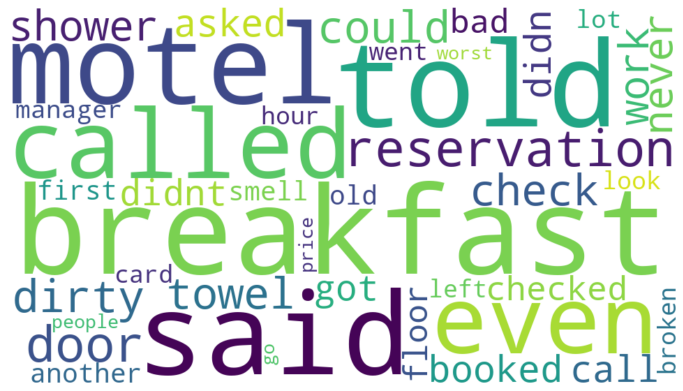

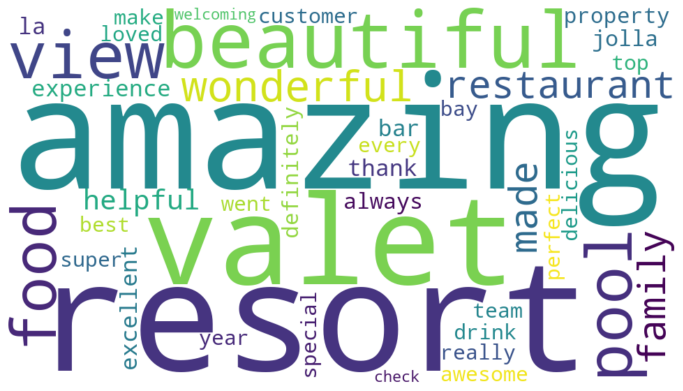

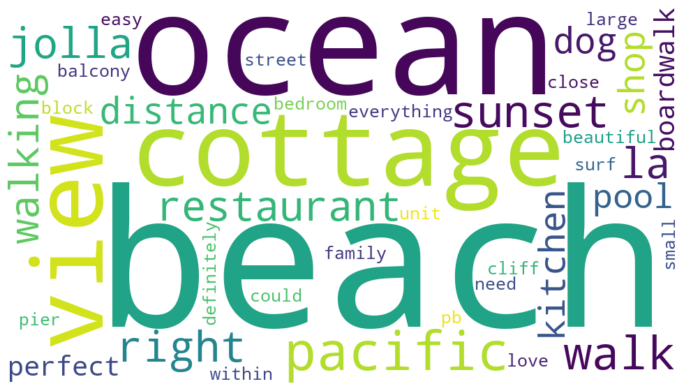

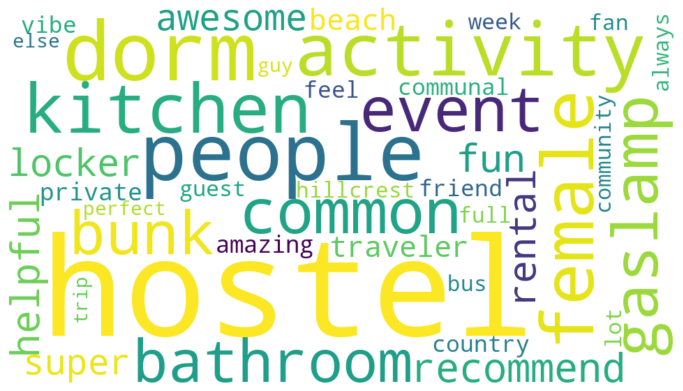

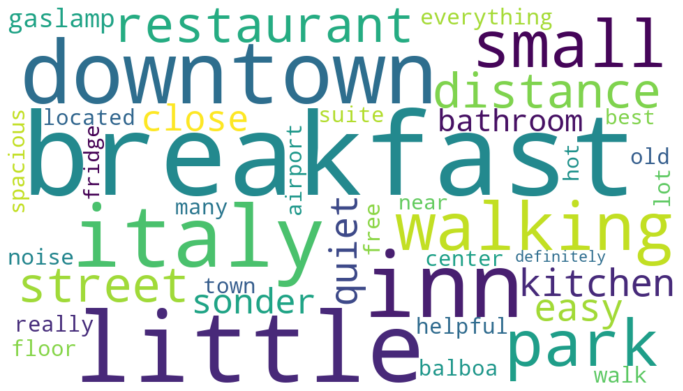

In [124]:
wordcloud_topics(nmf_summary_model, tfidf_summary_vectorizer.get_feature_names_out())

#### Wordcloud for the LDA Topic Model

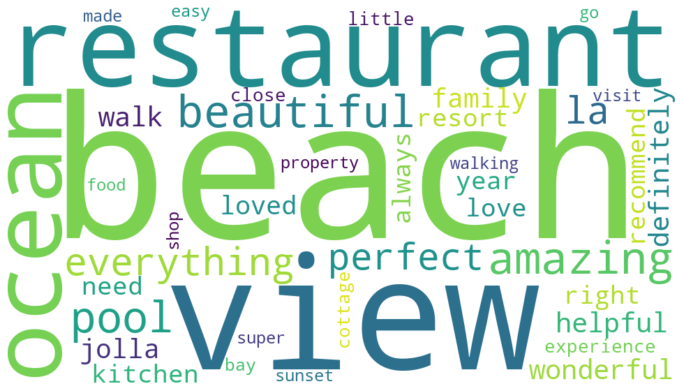

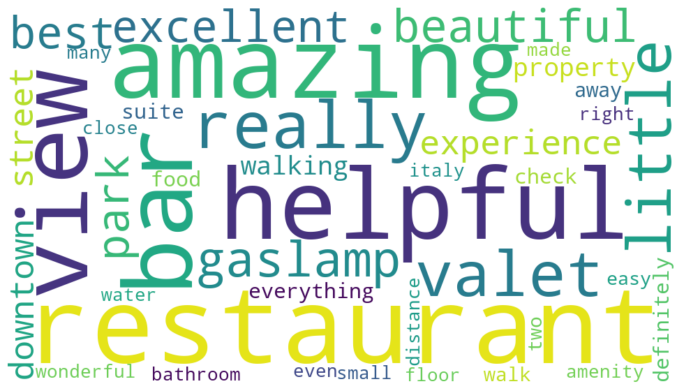

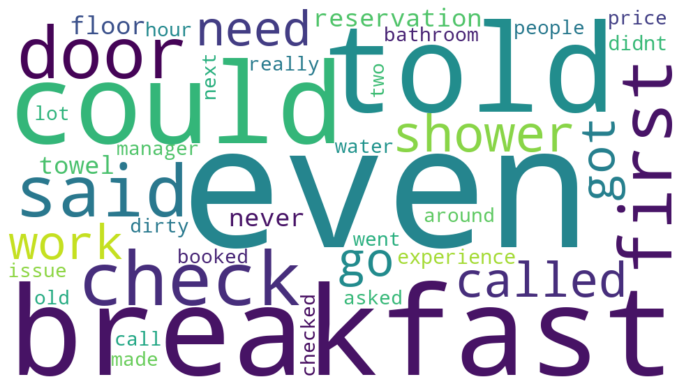

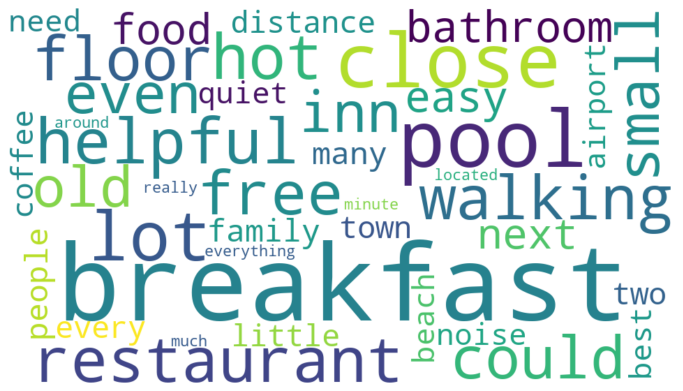

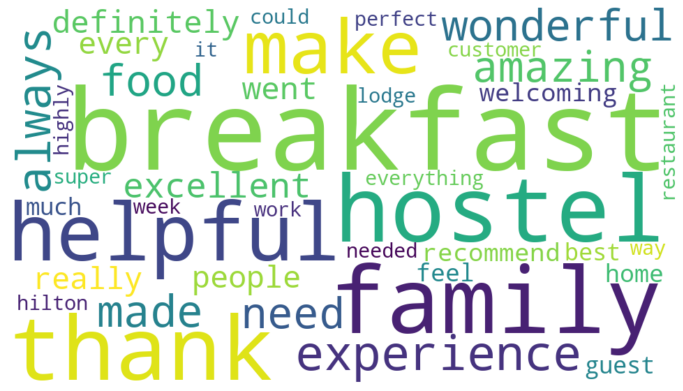

In [125]:
wordcloud_topics(LDA_summary_model, count_summary_vectorizer.get_feature_names_out())

There seems to be some overlap between some of the topics accross both models.